# Estimate Meter Reading From A Real Image

Using the model trained only on synthetic data, lets see how well it does with( a real image. This `predict_from_image` function accepts an image and a trained model and returns the estimated meter reading as well as some metadata (which can be used for visualizing/debugging what the model is doing)

In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

from model import load_model


def predict_from_image(image, model):
    model.eval()
    with torch.no_grad():
        metadata = model([torchvision.transforms.functional.convert_image_dtype(image, torch.float32)])[0]

    # there will likely be multiple overlapping predictions for the digits. this filters down to
    # only have one digit in each location, and returns them in order from left-to-right
    filtered_indices = sorted(
        torchvision.ops.nms(metadata['boxes'], metadata['scores'], iou_threshold=0.1).tolist(),
        key=lambda index: metadata['boxes'][index, 0].item()
    )

    # ignore the rest of the predictions
    metadata = {key: metadata[key][filtered_indices] for key in ('boxes', 'labels', 'scores')}

    # find the actual meter value by putting all of the detected digits together and dividing the number
    # by 10 to get true value
    digits = metadata['labels'] - 1
    meter_value = int(''.join(str(digit) for digit in digits.tolist())) / 10

    return meter_value, metadata

## Load the model

The learned parameters for the model are stored in the `meter_reading_model.pt` file. By loading through `load_model()` we have a model object that can be reused for predicting on multiple images (this is useful since the loading can take a bit of time)

In [9]:
model = load_model('meter_reading_model.pt')

## Load an image

In [10]:
full_image = torchvision.io.read_image('20220505_230125[4].jpg')

# images seem to be wrongly oriented, rotate CCW by 90 degrees
full_image = torch.rot90(full_image, k=-1, dims=(1, 2))

# manually defined crop, approximately around the display
image = full_image[:, 256:356, 205:405]

meter_value, metadata = predict_from_image(image, model)

## Visualize the result

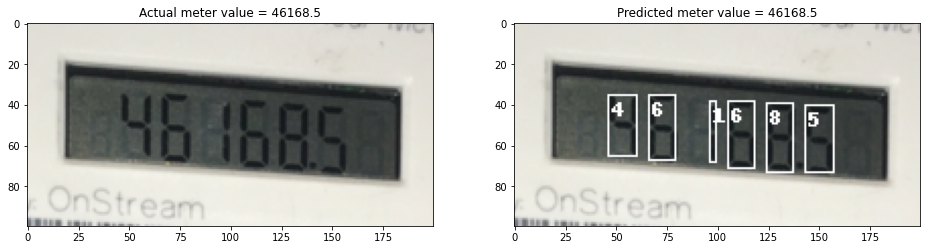

In [11]:
result = torchvision.utils.draw_bounding_boxes(
    image, metadata['boxes'], [str(label) for label in (metadata['labels'] - 1).tolist()],
)

fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(image.numpy().transpose(1, 2, 0))
axes[0].set_title(f'Actual meter value = {46168.5:.1f}')
axes[1].imshow(result.numpy().transpose(1, 2, 0))
axes[1].set_title(f'Predicted meter value = {meter_value:.1f}')
plt.show()